In [1]:
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
import os
current_dir = os.getcwd()
import sys
sys.path.append(r"E:\ITSolera\HMS\Structural_Health_Monitoring_System")


from Models.models import HybridModel


In [6]:
# Load test data

data = np.load("../Data/Processed/Testing_Prepared_Data/V2_featured_test.npz")
X= data["X_test"]
y= data["y_test"]

In [7]:
# Convert to torch tensors
X_test_tensor = torch.tensor(X, dtype=torch.float32)
y_test_tensor = torch.tensor(y, dtype=torch.long)




In [8]:
# Initialize model

# ==== Model Run ====

model = HybridModel(
    input_channels=19,
    cnn_channels=32,
    lstm_hidden=32,
    lstm_layers=2,
    num_classes=4
)# pass the best parameters from optuna used in train


In [10]:
# Load the saved state_dict
model.load_state_dict(torch.load("../Models/Trained_models/V2_Best_model.pth"))
model.eval()


HybridModel(
  (cnn): Sequential(
    (0): Conv1d(19, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): AdaptiveAvgPool1d(output_size=32)
  )
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [11]:
#  Run inference
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)


# Convert predictions to numpy
y_pred = predicted.numpy()
y_true = y_test_tensor.numpy()


In [12]:


# Print evaluation metrics
# Evaluation metrics
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)
print("Classification Report:\n", classification_report(y_true, y_pred))




Accuracy: 0.9626865671641791
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        37
           1       0.93      1.00      0.96        51
           2       1.00      0.95      0.97        37
           3       0.90      1.00      0.95         9

    accuracy                           0.96       134
   macro avg       0.96      0.97      0.96       134
weighted avg       0.97      0.96      0.96       134



In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = sorted(np.unique(y_true))





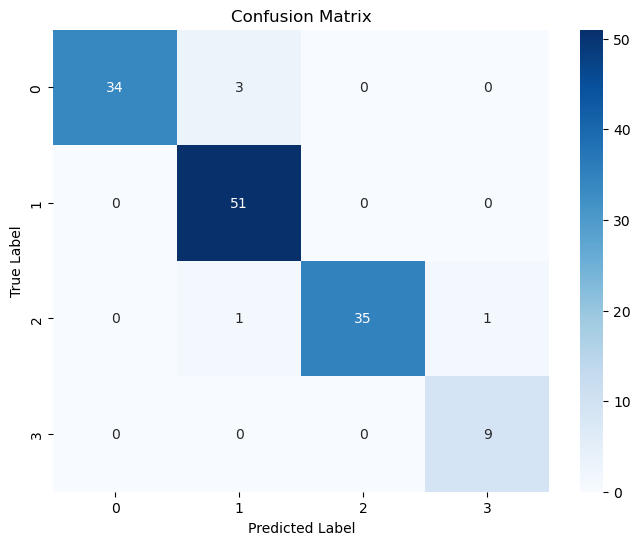

In [14]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


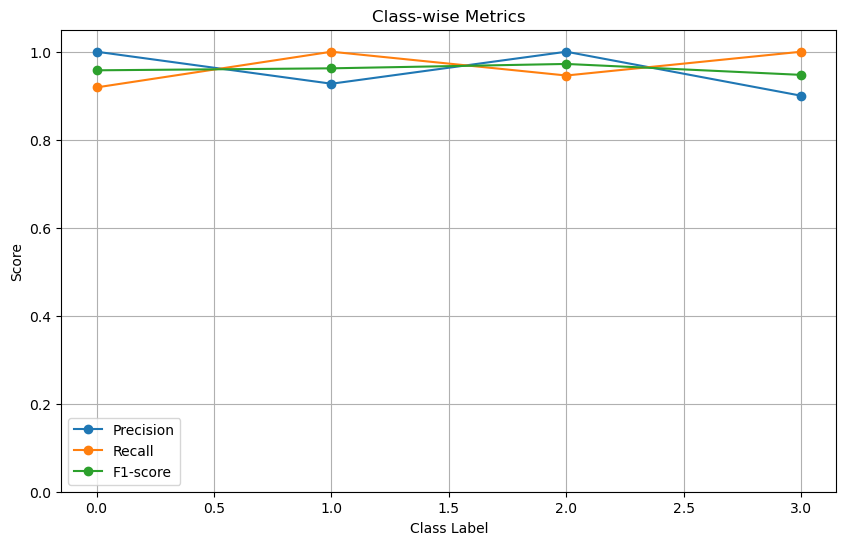

In [15]:

# Plot Class-wise Precision, Recall, F1
report = classification_report(y_true, y_pred, output_dict=True)
metrics_df = (
    np.array([[report[str(c)]["precision"], report[str(c)]["recall"], report[str(c)]["f1-score"]]
              for c in class_labels])
)

metrics_names = ["Precision", "Recall", "F1-score"]

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics_names):
    plt.plot(class_labels, metrics_df[:, i], marker='o', label=metric)

plt.ylim(0, 1.05)
plt.xlabel("Class Label")
plt.ylabel("Score")
plt.title("Class-wise Metrics")
plt.legend()
plt.grid(True)
plt.show()

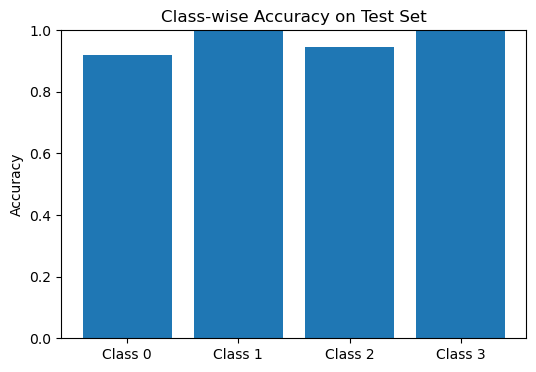

In [16]:
# ==== Optional: Class-wise Accuracy Visualization ====
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(6,4))
plt.bar(range(len(class_acc)), class_acc)
plt.xticks(range(len(class_acc)), [f"Class {i}" for i in range(len(class_acc))])
plt.ylabel("Accuracy")
plt.title("Class-wise Accuracy on Test Set")
plt.ylim(0,1)
plt.show()